In [ ]:
#hide
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
#%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
from fastprogress.fastprogress import master_bar, progress_bar
from time import sleep
import numpy as np
import random

epochs = 5

mb1 = master_bar(range(1, epochs*2))
for m in mb1:
    mb = progress_bar(range(1, epochs+1), parent=mb1)
    # optional: graph legend: if not set, the default is 'train'/'valid'
    # mb.names = ['first', 'second']
    train_loss, valid_loss = [], []
    for epoch in mb:
        # emulate train sub-loop
        for batch in progress_bar(range(2), parent=mb1): sleep(0.2)
        train_loss.append(0.5 - 0.06 * epoch + random.uniform(0, 0.04))

        # emulate validation sub-loop
        for batch in progress_bar(range(2), parent=mb1): sleep(0.2)
        valid_loss.append(0.5 - 0.03 * epoch + random.uniform(0, 0.04))


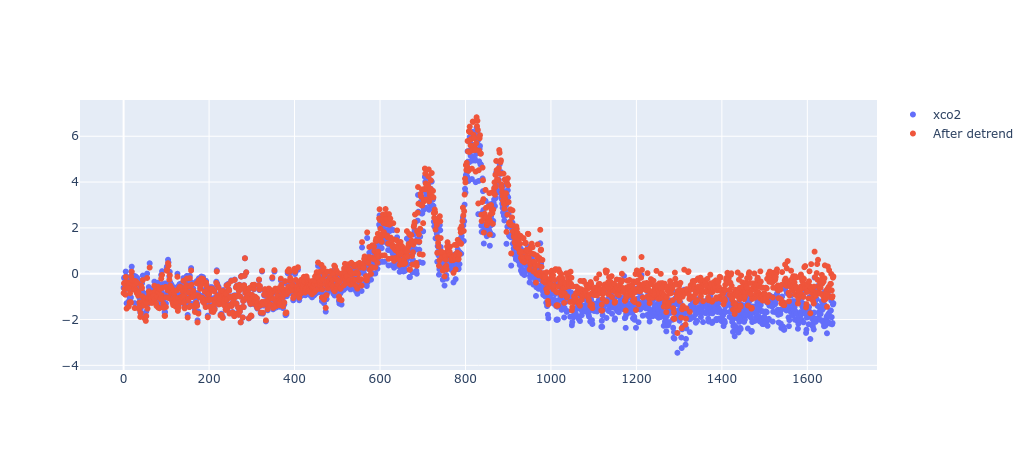

In [17]:
import plotly.graph_objects as go
import numpy as np
from scipy import signal
df_test = df_peak.copy()
df_test.xco2 = df_test.xco2 - gaussian_param['intercept']
randgen = np.random.RandomState(9)
npoints = 1000
noise = randgen.randn(npoints)
y1 = df_test.xco2
y2 = signal.detrend(y1)

fig = go.Figure()

# Add traces
_ = fig.add_trace(go.Scatter( y=y1,mode='markers', name='xco2'))
_ = fig.add_trace(go.Scatter( y=y2, mode='markers', name='After detrend'))
fig.show()

In [18]:

def preprocess_for_fit(df_orbit, peak, N_sample=10000, N_quantiles=200, window=200, window_rolling_avg=10):

#     km_start = df_orbit.set_index("sounding_id").loc[peak['sounding_id'], 'distance']
#     print(km_start)
    df_slice = df_orbit
#     df_slice = df_orbit.loc[(df_orbit["distance"] >= km_start.iloc[0] - window/2) &
#                             (df_orbit["distance"] <= km_start.iloc[0] + window/2), :]
    #x = df_slice['distance'] - km_start.iloc[0]
    x = df_slice['distance']
    y = df_slice['xco2']
    X = pd.concat([x, y], axis=1)
    X = X.sort_values("distance")
    #plt.scatter(x, y, c=y, s=3, label='Observed data')
    # On réduit le bruit en prenant des bins
    X["bins"] = pd.qcut(x, N_quantiles)
    X = X.groupby("bins").agg({"distance": "mean", "xco2": "mean"})
    # then take rolling average to smooth curve
    X = X.rolling(window=window_rolling_avg).mean()
    X = X.dropna()
    #plt.scatter(X.distance, X.xco2, c=X.xco2, s=3, label='Binned data')
    X = X.values
    # fit du gaussian mixture
    distance, co2 = X[:, 0], X[:, 1]
    n_distance = distance
#     min_co2 = min(co2)
#     n_co2 = (co2 - min_co2)/(sum(co2-min_co2))
#     assert round(n_co2.sum()) == 1

    # Generate a distribution of points matcthing the curve
    line_distribution = np.random.choice(a=n_distance, size=N_sample, p=n_co2)
    number_points = len(line_distribution)
    return line_distribution, number_points, n_distance, n_co2


In [19]:
from sklearn import mixture
from scipy.stats import norm
distance
begin = distance - 100
end = distance + 100
df_peak = df_11522.query("distance > @begin and distance < @end")
df_peak.distance.min()
df_peak.distance.max()
df_peak.distance = df_peak.distance - distance
df_peak.distance.min()
df_peak.distance.max()
df_peak.xco2 = df_peak.xco2 - gaussian_param['intercept']
line_distribution, number_points, n_distance, n_co2 = preprocess_for_fit(df_peak, gaussian_param, N_sample=10000,
                                                                             N_quantiles=200,
                                                                             window=200)
# Run the fit
gmm = mixture.GaussianMixture(n_components=5, random_state=12)
gmm.fit(np.reshape(line_distribution, (number_points, 1)))
gauss_mixt = np.array([p * norm.pdf(n_distance, mu, sd) for mu, sd, p in zip(gmm.means_.flatten(),
                                                                             np.sqrt(gmm.covariances_.flatten()),
                                                                             gmm.weights_)])
gauss_mixt_t = np.sum(gauss_mixt, axis=0)


549.0363373090963

449.8418498490297

648.9306179916058

/media/data-nvme/dev/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



-99.19448746006663

99.89428068250947

NameError: name 'n_co2' is not defined

In [ ]:
fig = go.Figure()
_ = fig.add_trace(go.Scatter(x=df_peak.distance, y=df_peak.xco2, mode='markers', name='markers'))
fig.show()
fig = go.Figure()
_ = fig.add_trace(go.Scatter(x=n_distance, y=n_co2, mode='markers', name='Moving average'))
_ = fig.add_trace(go.Scatter(x=n_distance, y=gauss_mixt_t, mode='markers', name='gaussian mixture'))
fig.show()

In [ ]:
distance


In [ ]:
from matplotlib import pyplot as plt
import numpy as np

from sklearn.linear_model import (
    LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor, BayesianRidge)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.tree import DecisionTreeRegressor

X=df_peak.distance.to_numpy()
Y=df_peak.xco2.to_numpy()

# transform the dataset with KBinsDiscretizer
enc = KBinsDiscretizer(n_bins=100, encode='onehot')
X_binned = enc.fit_transform(X.reshape(-1, 1))
line = np.linspace(min(X), max(X), 200, endpoint=False).reshape(-1, 1)
X_binned

estimators = [('OLS', LinearRegression()),
               ('Theil-Sen', TheilSenRegressor(random_state=42)),
               ('RANSAC', RANSACRegressor(random_state=42)),
               #('HuberRegressor', HuberRegressor()),
             ('BayesianRidge', BayesianRidge()),
             #('DecisionTreeRegressor', DecisionTreeRegressor())
            ]

fig = go.Figure()
_ = fig.add_trace(go.Scatter(x=X, y=Y, mode='markers', name='xco2'))
for name, estimator in estimators:
    model = make_pipeline(PolynomialFeatures(15), estimator)
    #model = estimator
    model.fit(X.reshape(-1, 1), Y)
    #mse = mean_squared_error(model.predict(X), Y)
    y_plot = model.predict(line)
    _ = fig.add_trace(go.Scatter(x=np.squeeze(line), y=np.squeeze(y_plot), mode='markers', name=name))
#     plt.plot(x_plot, y_plot, color=colors[name], linestyle=linestyle[name],
#              linewidth=lw, label='%s: error = %.3f' % (name, mse))

# legend_title = 'Error of Mean\nAbsolute Deviation\nto Non-corrupt Data'
# legend = plt.legend(loc='upper right', frameon=False, title=legend_title,
#                     prop=dict(size='x-small'))
fig['layout']['yaxis1'].update(title='', range=[-1, +8], dtick=1, autorange=False)
fig.show()

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.tree import DecisionTreeRegressor

print(__doc__)

# construct the dataset
rnd = np.random.RandomState(42)
X=df_peak.distance.to_numpy()
y=df_peak.xco2.to_numpy()
X = X.reshape(-1, 1)

# transform the dataset with KBinsDiscretizer
enc = KBinsDiscretizer(n_bins=100, encode='onehot')
X_binned = enc.fit_transform(X)

# predict with original dataset
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(25, 8))
line = np.linspace(min(X), max(X), 1000, endpoint=False).reshape(-1, 1)
reg = LinearRegression().fit(X, y)
ax1.plot(line, reg.predict(line), linewidth=2, color='green',
         label="linear regression")
reg = DecisionTreeRegressor(min_samples_split=3, random_state=0).fit(X, y)
ax1.plot(line, reg.predict(line), linewidth=2, color='red',
         label="decision tree")
ax1.plot(X[:, 0], y, 'o', c='k')
ax1.legend(loc="best")
ax1.set_ylabel("Regression output")
ax1.set_xlabel("Input feature")
ax1.set_title("Result before discretization")

# predict with transformed dataset
line_binned = enc.transform(line)
y = signal.detrend(y)
reg = LinearRegression().fit(X_binned, y)
ax2.plot(line, reg.predict(line_binned), linewidth=2, color='green',
         linestyle='-', label='linear regression')
reg = DecisionTreeRegressor(min_samples_split=3,
                            random_state=0).fit(X_binned, y)
ax2.plot(line, reg.predict(line_binned), linewidth=2, color='red',
         linestyle=':', label='decision tree')
ax2.plot(X[:, 0], y, 'o', c='k', alpha=0.2)
ax2.vlines(enc.bin_edges_[0], *plt.gca().get_ylim(), linewidth=1, alpha=.2)
ax2.legend(loc="best")
ax2.set_xlabel("Input feature")
ax2.set_title("Result after discretization")

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#first generate some datapoint for a randomly sampled noisy sinewave
# x = np.random.random(1000)*10
# noise = np.random.normal(scale=0.3,size=len(x))
# y = np.sin(x) + noise
X=df_peak.distance.to_numpy()
y=df_peak.xco2.to_numpy()
X = X.reshape(-1, 1)
#plot the data
plt.plot(x,y,'ro',alpha=0.3,ms=4,label='data')
plt.xlabel('Time')
plt.ylabel('Intensity')

#define a moving average function
def moving_average(x,y,step_size=.1,bin_size=1):
    bin_centers  = np.arange(np.min(x),np.max(x)-0.5*step_size,step_size)+0.5*step_size
    bin_avg = np.zeros(len(bin_centers))

    for index in range(0,len(bin_centers)):
        bin_center = bin_centers[index]
        items_in_bin = y[(x>(bin_center-bin_size*0.5) ) & (x<(bin_center+bin_size*0.5))]
        bin_avg[index] = np.mean(items_in_bin)

    return bin_centers,bin_avg

def weighted_moving_average(x,y,step_size=0.05,width=1):
    bin_centers  = np.arange(np.min(x),np.max(x)-0.5*step_size,step_size)+0.5*step_size
    bin_avg = np.zeros(len(bin_centers))

    #We're going to weight with a Gaussian function
    def gaussian(x,amp=1,mean=0,sigma=1):
        return amp*np.exp(-(x-mean)**2/(2*sigma**2))

    for index in range(0,len(bin_centers)):
        bin_center = bin_centers[index]
        weights = gaussian(x,mean=bin_center,sigma=width)
        bin_avg[index] = np.average(y,weights=weights)

    return (bin_centers,bin_avg)

#plot the moving average
bins, average = moving_average(x,y)
plt.plot(bins, average,label='moving average')
bins, average = weighted_moving_average(x,y)
plt.plot(bins, average,label='weighted_moving_average average')

plt.show()